# Check out GPU type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 23 17:57:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    36W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Check out RAM size

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# 1. Install dependencies

In [3]:
!pip install -q transformers

# 3. Use a specific sentiment analysis model available on the Hub by specifying its name

In [4]:
# Using pipeline class to make predictions from models available in the Hub in an easy way 
from transformers import pipeline

In [5]:
# Using a specific model for sentiment analysis
specific_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=0)
data = ["I love you", "I hate you"]
specific_model(data)

[{'label': '5 stars', 'score': 0.8546808362007141},
 {'label': '1 star', 'score': 0.6346071362495422}]

# 4. Read in 12 dataset

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
% cd drive/MyDrive/bigdata/final/data/

/content/drive/MyDrive/bigdata/final/data


In [7]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
spark = SparkSession.builder.appName('sentiment').getOrCreate()

In [9]:
schema = StructType([ \
    StructField("marketplace",       StringType(),    True), \
    StructField("customer_id",       StringType(),    True), \
    StructField("review_id",         StringType(),    True), \
    StructField("product_id",        StringType(),    True), \
    StructField("product_parent",    StringType(),    True), \
    StructField("product_title",     StringType(),    True), \
    StructField("product_category",  StringType(),    True), \
    StructField("star_rating",       IntegerType(),   True), \
    StructField("helpful_votes",     IntegerType(),   True), \
    StructField("total_votes",       IntegerType(),   True), \
    StructField("vine",              StringType(),    True), \
    StructField("verified_purchase", StringType(),    True), \
    StructField("review_headline",   StringType(),    True), \
    StructField("review_body",       StringType(),    True), \
    StructField("review_date",       TimestampType(), True), \
  ])

path = ['archive/amazon_reviews_us_Apparel_v1_00.tsv',
        'archive/amazon_reviews_us_Automotive_v1_00.tsv',
        'archive/amazon_reviews_us_Baby_v1_00.tsv',
        'archive/amazon_reviews_us_Beauty_v1_00.tsv',
        'archive/amazon_reviews_us_Books_v1_02.tsv',
        'archive/amazon_reviews_us_Camera_v1_00.tsv',
        'archive/amazon_reviews_us_Electronics_v1_00.tsv',
        'archive/amazon_reviews_us_Furniture_v1_00.tsv',
        'archive/amazon_reviews_us_Sports_v1_00.tsv',
        'archive/amazon_reviews_us_Grocery_v1_00.tsv',
        'archive/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv',
        'archive/amazon_reviews_us_Music_v1_00.tsv']

data = spark.read.csv(path, schema=schema, header=True, sep='\t', mode='DROPMALFORMED')

In [15]:
data.count()

37173725

In [15]:
product_category = ['Sports', 'Baby', 'Apparel', 'Grocery', 'Electronics', 'Automotive', 'Books', 'Music', 'Furniture', 'Personal_Care_Appliances', 'Camera', 'Beauty']
data = data.filter(data.product_category.isin(product_category))
df_count = data.groupBy('product_category').count()
df_count.show(df_count.count())

+--------------------+-------+
|    product_category|  count|
+--------------------+-------+
|             Apparel|5906322|
|          Automotive|3514709|
|                Baby|1752932|
|              Beauty|5115452|
|               Books|3105515|
|              Camera|1801972|
|         Electronics|3093861|
|           Furniture| 792113|
|              Sports|4849563|
|             Grocery|2402431|
|               Music|4751540|
|Personal_Care_App...|  85981|
+--------------------+-------+



# 5. Read in each dataset one by one and Concatenate review headline and body as review

In [20]:
from numpy import NaN
product_category = ['Sports', 'Baby', 'Apparel', 'Grocery', 'Electronics', 'Automotive', 'Books', 'Music', 'Furniture', 'Personal_Care_Appliances', 'Camera', 'Beauty']
p = product_category[8]
df = pd.read_csv("archive/amazon_reviews_us_" + p + "_v1_00.tsv", sep='\t', error_bad_lines=False)
df = df[df['product_category'] == p]
df['review'] = df['review_headline'] + ". " + df['review_body']
df['prediction'] = None
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 2645: expected 15 fields, saw 22\nSkipping line 10770: expected 15 fields, saw 22\nSkipping line 13472: expected 15 fields, saw 22\nSkipping line 15785: expected 15 fields, saw 22\nSkipping line 22792: expected 15 fields, saw 22\nSkipping line 26618: expected 15 fields, saw 22\n'
b'Skipping line 70872: expected 15 fields, saw 22\nSkipping line 71165: expected 15 fields, saw 22\nSkipping line 118103: expected 15 fields, saw 22\n'
b'Skipping line 148666: expected 15 fields, saw 22\nSkipping line 150834: expected 15 fields, saw 22\nSkipping line 169344: expected 15 fields, saw 22\n'
b'Skipping line 197223: expected 15 fields, saw 22\nSkipping line 212607: expected 15 fields, saw 22\nSkipping line 227765: expected 15 fields, saw 22\nSkipping

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review,prediction
0,US,24509695,R3VR960AHLFKDV,B004HB5E0E,488241329,Shoal Creek Computer Desk,Furniture,4,0,0,N,Y,... desk is very study and it i has a beautifu...,This desk is very study and it i has a beauti...,2015-08-31,... desk is very study and it i has a beautifu...,None
1,US,34731776,R16LGVMFKIUT0G,B0042TNMMS,205864445,Dorel Home Products Delaney Large Rectangular ...,Furniture,5,0,0,N,Y,Five Stars,Great item,2015-08-31,Five Stars. Great item,None
2,US,1272331,R1AIMEEPYHMOE4,B0030MPBZ4,124663823,Bathroom Vanity Table Jewelry Makeup Desk Benc...,Furniture,5,1,1,N,Y,Five Stars,"Perfect fit for my bedroom, been wanting one s...",2015-08-31,"Five Stars. Perfect fit for my bedroom, been w...",None
3,US,45284262,R1892CCSZWZ9SR,B005G02ESA,382367578,Sleep Master Ultima Comfort Memory Foam 6 Inch...,Furniture,3,0,0,N,Y,Good enough,"We use this on a trundle bed. So, it does not...",2015-08-31,Good enough. We use this on a trundle bed. So...,None
4,US,30003523,R285P679YWVKD1,B005JS8AUA,309497463,"1 1/4"" GashGuards: Deluxe Rubberized Plastic B...",Furniture,3,0,0,N,N,Gash Gards for daybed,The product is fine...just seemed like it took...,2015-08-31,Gash Gards for daybed. The product is fine...j...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791668,US,52940456,R1F7BNIK2R72ZC,B000050FF8,161996292,HoMedics BLTW-100 21-Inch AquaScape Twist Bubb...,Furniture,5,21,21,N,N,A great deal!,I sort of collect water fountains and most hav...,2000-11-07,A great deal!. I sort of collect water fountai...,None
791669,US,50562473,RVR3U3QA0D95B,B00000K0CL,328789022,Midnight Motion Lamp with White Lava and Blue ...,Furniture,5,10,11,N,N,This Lava Lamp is great!,I just got my lava lamp 2 days ago and I just ...,2000-10-28,This Lava Lamp is great!. I just got my lava l...,None
791670,US,51137498,R1X5JB9UJRZW31,B00004SZ5M,547720134,Maglite Solitaire Incandescent 1-Cell AAA Flas...,Furniture,5,3,5,N,N,You can't go wrong owning one of these,"This is similar to other mag-lites, except in ...",2000-07-16,You can't go wrong owning one of these. This i...,None
791671,US,49843940,R235PHRTF7BFK7,B00004SBJJ,685482907,"Le Creuset Stoneware 1-Quart Crock, White",Furniture,4,5,5,N,N,Everybody can use a little Le Creuset,I purchased this little pot as a gift for a fr...,2000-06-12,Everybody can use a little Le Creuset. I purch...,None


## Make rating star predictions from 1 to 5 with Transformer sentiment analysis Pre-trained model

In [21]:
import time

start = time.time()
count = 0

for i in range(df.shape[0]):
  try:
    star = int(specific_model(df.at[i, 'review'])[0]['label'].split(' ')[0])
    df.at[i, 'prediction'] = star
  except:
    count = count + 1

end = time.time()
print((end - start)/60)

df.to_csv("pred/" + p + ".csv", index=False)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Token indices sequence length is longer than the specified maximum sequence length for this model (921 > 512). Running this sequence through the model will result in indexing errors


139.8974901119868


## Visualize the confusion matrix with heatmap

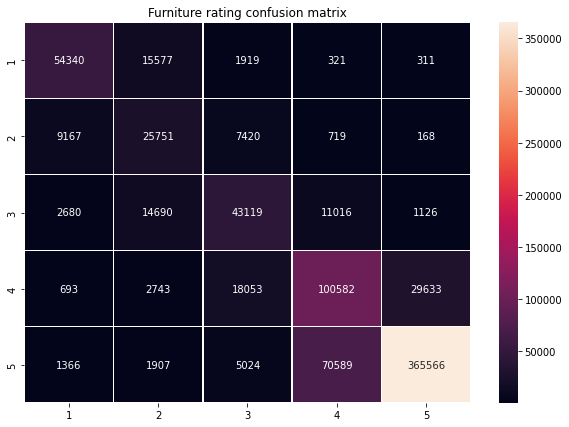

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

df_drop = df.dropna()
df_drop = df_drop.astype({'prediction': 'int'})

array = confusion_matrix(y_true=df_drop['star_rating'], y_pred=df_drop['prediction'], labels = [1,2,3,4,5])

df_cm = pd.DataFrame(array, index = [i for i in [1,2,3,4,5]],
                  columns = [i for i in [1,2,3,4,5]])

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax);
ax.set_title(f'{p} rating confusion matrix')
plt.show()